In [ ]:
!pip install torch==1.11.0  # version recommended by source
!pip install git+https://github.com/gretelai/gretel-synthetics.git

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn.preprocessing import MinMaxScaler
from pickle import dump, load
from skimage.util.shape import view_as_windows
import time

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

In [3]:
slice0 = pd.read_csv('../data/kagglePump/slice0.csv') 
slice1 = pd.read_csv('../data/kagglePump/slice1.csv') 
slice2 = pd.read_csv('../data/kagglePump/slice2.csv')
slice3 = pd.read_csv('../data/kagglePump/slice3.csv') 
slice4 = pd.read_csv('../data/kagglePump/slice4.csv')
slice5 = pd.read_csv('../data/kagglePump/slice5.csv') 
slice6 = pd.read_csv('../data/kagglePump/slice6.csv') 


print(slice0.shape, slice1.shape, slice2.shape, slice3.shape, slice4.shape, slice5.shape, slice6.shape)

(3601, 6) (3601, 6) (3601, 6) (3601, 6) (3601, 6) (3601, 6) (3601, 6)


In [4]:
slice0.tail()

,timestamp,sensor_25,sensor_11,sensor_36,sensor_34,machine_status
3596,2018-04-12 21:51:00,655.7155,28.343960,295.7441,249.9119,0.0
3597,2018-04-12 21:52:00,657.5817,28.638560,293.1167,253.6228,0.0
3598,2018-04-12 21:53:00,657.5817,28.347830,293.1167,253.6228,0.0
3599,2018-04-12 21:54:00,654.5527,16.553430,298.8596,250.4138,0.0
3600,2018-04-12 21:55:00,653.9383,3.625588,301.1411,261.7709,1.0


In [5]:
# prep for plotting
slices_list = [slice0, slice1, slice2, slice3, slice4, slice5, slice6]
sensor_cols = ['sensor_25', 'sensor_11', 'sensor_36', 'sensor_34']

# cast timestamps to be type datetime
for sl in slices_list:
    sl['timestamp']= pd.to_datetime(sl['timestamp'])

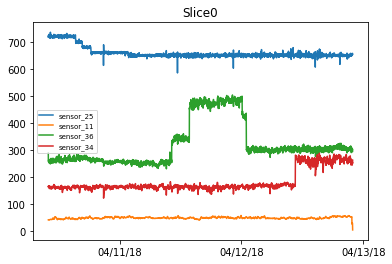

In [6]:
def plot_slice(slice, ind):
    
    for i, c in enumerate(sensor_cols):
        plt.plot(slice['timestamp'], slice[c], label=c)
    ax = plt.gca()
    ax.title.set_text("Slice" +str(ind))
    ax.xaxis.set_minor_locator(md.DayLocator(interval=1))
    ax.xaxis.set_major_locator(md.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(md.DateFormatter("%D"))
    plt.legend(prop={'size': 7})
    
# test plotting func
plot_slice(slices_list[0],0)
plt.show()

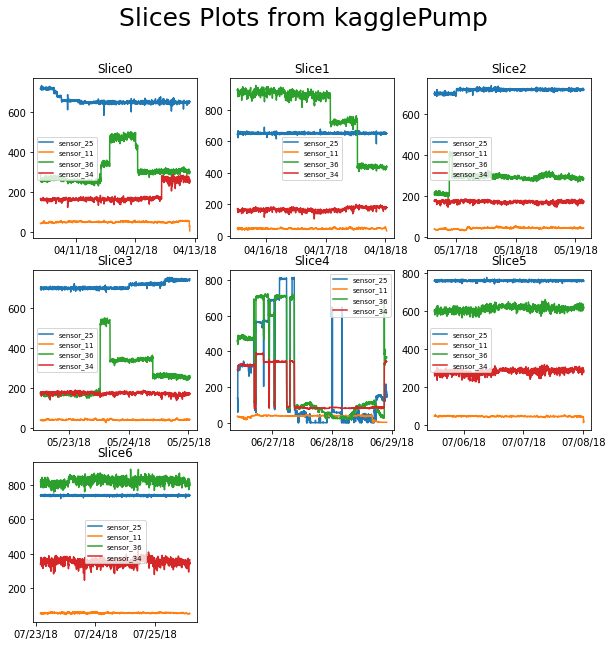

In [7]:
# lets plot them all

figure = plt.figure(figsize=(10, 10))
figure.suptitle("Slices Plots from kagglePump", fontsize=25, fontweight='roman')

for i, sl in enumerate(slices_list):
    figure.add_subplot(3, 3, i+1)
    plot_slice(sl, i)
    
plt.show()


In [8]:
# dropping timestamp, machine status from slices, converting to np from df
# also dropped the first element from each to make them an even 3600

for i in range(len(slices_list)):
    slices_list[i] = slices_list[i].drop(columns=["timestamp","machine_status"]).to_numpy()
    slices_list[i] = np.array(slices_list[i][1:])
    print(slices_list[i].shape)



(3600, 4)
(3600, 4)
(3600, 4)
(3600, 4)
(3600, 4)
(3600, 4)
(3600, 4)


In [9]:
# removing the slice4 as its too different from the others.

slices_list.pop(4)

print(len(slices_list))

6


In [10]:
slices_list = np.asarray(slices_list)
slices_list.shape

(6, 3600, 4)

In [11]:
# we have shape 6,3601, 4. 
# we want something closer to 300,720,4.
# 300 being num training samples, 720 being datapoints per sample (12 hrs), 4 sensor cols.
window_shape = (720, 4)
windowed_data = view_as_windows(slices_list[0], window_shape, step=58)
windowed_data = np.squeeze(windowed_data)
windowed_data.shape

(50, 720, 4)

In [12]:
# alright, there we have 50 windows of 12hr data from our first slice.
# lets get 50 windows from our other 5 slices

for i in range(1,6):
    temp_window = view_as_windows(slices_list[i], window_shape, step=58)
    temp_window = np.squeeze(temp_window)
    windowed_data = np.append(windowed_data, temp_window, axis=0)

In [13]:
windowed_data.shape

(300, 720, 4)

In [14]:
def plot_12hr_slice(slice, ind):
    
    for i, c in enumerate(sensor_cols):
        plt.plot(slice[:,i], label=c)
    ax = plt.gca()
    ax.title.set_text("Slice" +str(ind))
    plt.legend(prop={'size': 7})

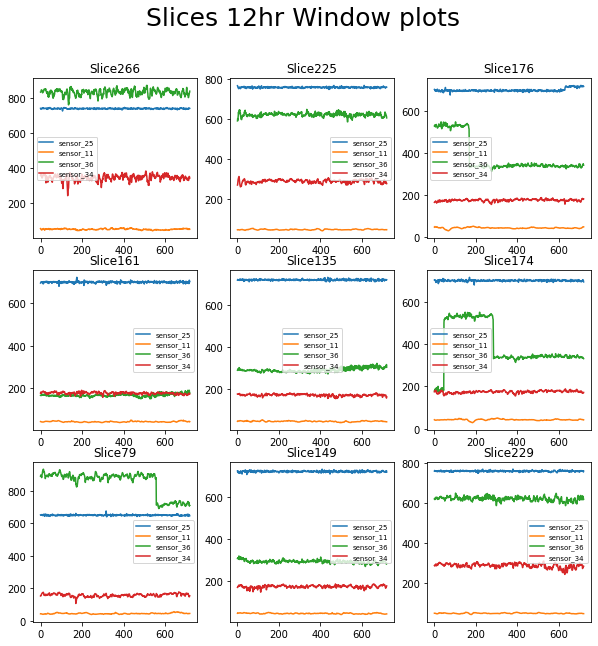

In [23]:
# plot random windows

figure = plt.figure(figsize=(10, 10))
figure.suptitle("Slices 12hr Window plots", fontsize=25, fontweight='roman')

for i in range(9):
    figure.add_subplot(3, 3, i+1)
    index = np.random.choice(300)
    sl = windowed_data[index]
    plot_12hr_slice(sl, index)
    
plt.show()

In [16]:
# Recommended to train with a GPU 
torch.cuda.is_available()

True

In [17]:
# set up DGAN config.

config = DGANConfig(
    max_sequence_len=windowed_data.shape[1],
    sample_len=20, # trying a larger sample_len
    batch_size=min(1000, windowed_data.shape[0]),
    apply_feature_scaling=True, 
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000)

model = DGAN(config)

In [18]:
start = time.time()
model.train_numpy(
    windowed_data,
    feature_types=[OutputType.CONTINUOUS] * windowed_data.shape[2],
)
stop = time.time()
print(f"Training time: {stop - start}s")

2022-07-18 15:30:24,898 : MainThread : INFO : epoch: 0
2022-07-18 15:30:25,118 : MainThread : INFO : epoch: 1
2022-07-18 15:30:25,196 : MainThread : INFO : epoch: 2
2022-07-18 15:30:25,267 : MainThread : INFO : epoch: 3
2022-07-18 15:30:25,340 : MainThread : INFO : epoch: 4
2022-07-18 15:30:25,403 : MainThread : INFO : epoch: 5
2022-07-18 15:30:25,467 : MainThread : INFO : epoch: 6
2022-07-18 15:30:25,546 : MainThread : INFO : epoch: 7
2022-07-18 15:30:25,609 : MainThread : INFO : epoch: 8
2022-07-18 15:30:25,676 : MainThread : INFO : epoch: 9
2022-07-18 15:30:25,737 : MainThread : INFO : epoch: 10
2022-07-18 15:30:25,795 : MainThread : INFO : epoch: 11
2022-07-18 15:30:25,857 : MainThread : INFO : epoch: 12
2022-07-18 15:30:25,927 : MainThread : INFO : epoch: 13
2022-07-18 15:30:26,014 : MainThread : INFO : epoch: 14
2022-07-18 15:30:26,085 : MainThread : INFO : epoch: 15
2022-07-18 15:30:26,164 : MainThread : INFO : epoch: 16
2022-07-18 15:30:26,237 : MainThread : INFO : epoch: 17
20

Training time: 660.2164249420166s


In [28]:
print(f"Training time: {stop - start}s")

Training time: 660.2164249420166s


In [29]:
# saving model for future use 
model.save("dgan_model_2.pt")

In [21]:
# Generate synthetic data - this ran near instantly
_, synthetic_features = model.generate_numpy(1000)

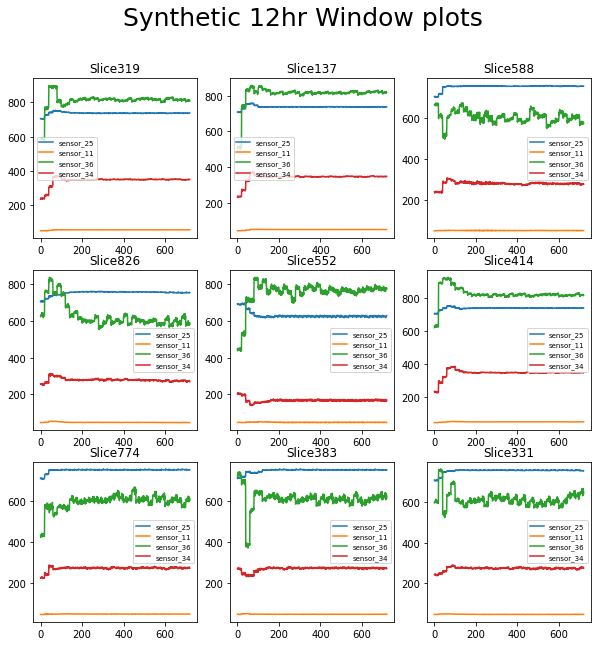

In [26]:
# plot random synthetic windows

figure = plt.figure(figsize=(10, 10))
figure.suptitle("Synthetic 12hr Window plots", fontsize=25, fontweight='roman')

for i in range(9):
    figure.add_subplot(3, 3, i+1)
    index = np.random.choice(1000)
    sl = synthetic_features[index]
    plot_12hr_slice(sl, index)
    
plt.show()